**Exemplo 2 Carregando modelo pré-treinado utilizando base propria**

* Primeiro passo, habilite o drive em seu colab ao lado esquerdo da IDE

* Segundo passo, adicione a base CatsAndDogs em sua pasta Meu Drive no seu Drive

* Link para base ->: https://drive.google.com/drive/folders/1srR7tCUnM9MVqB9x8RGaK9SG7BrhToJt?usp=sharing

* Habilite a funcionalidade de GPU ou TPU na plataforma

* Editar - Configurações de notebook - GPU ou TPU

# Nova seção

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
_____________________________________________________________________________________

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
12/12 [==============================] - 45s 3s/step - loss: 0.7004 - accuracy: 0.5915 - val_loss: 0.3849 - val_accuracy: 0.8854
Epoch 2/5
12/12 [==============================] - 41s 4s/step - loss: 0.3790 - accuracy: 0.8528 - val_loss: 0.2508 - val_accuracy: 0.9479
Epoch 3/5
12/12 [==============================] - 41s 3s/step - loss: 0.2644 - accuracy: 0.8898 - val_loss: 0.1738 - val_accuracy: 0.9688
Epoch 4/5
12/12 [==============================] - 41s 4s/step - loss: 0.2425 - accuracy: 0.9043 - val_loss: 0.1373 - val_accuracy: 0.9688
Epoch 5/5
12/12 [==============================] - 45s 4s/step - loss: 0.1662 - accuracy: 0.9398 - val_loss: 0.1118 - val_accuracy: 0.9583


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.992, Test: 0.969


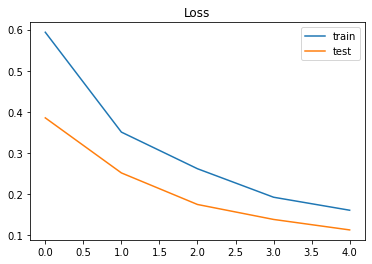

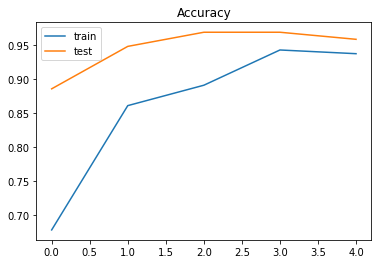

Criando classificações..


FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'drive/My Drive/CatsAndDogs/Train'

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os

epochs = 5
batch = 32

#carrega o modelo da inception_v3 com os pesos aprendidos no treino da ImageNet sem a camada densa (include_top=False)

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)


#O restante do modelo e suas camadas são discutidos a seguir
#x recebe o final da inception_v3

x=base_model.output

#Nova configuração para o modelo


#adiciona apos x uma camada AveragePooling2D e atribui este no a x novamente (logo x e o topo novamente)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#adiciona apos x uma camada densa com 32 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(128,activation='relu')(x)

#adiciona apos x uma camada densa com 64 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(64,activation='relu')(x)

#adiciona apos x uma camada densa com 128 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(32,activation='relu')(x)

#adiciona após x os neurônios que devem ser utilizados, nesse caso foram desligados 20% dos neuronios
x=tf.keras.layers.Dropout(0.5)(x)

#adiciona apos x uma camada densa com 2 neuronios (duas classes) com funcao de ativacao softmax (distribuicao de probabilidade). Atribui este no a preds
preds=tf.keras.layers.Dense(2,activation='softmax')(x)

#definindo modelo final
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#mostrando modelo final e sua estrutura
model.summary()

#congelando os neuronios já treinados na ImageNet, queremos retreinar somente a ultima camada
for l in model.layers:
    if l.name.split('_')[0] != 'dense':
        l.trainable=False
    else:
        l.trainable=True


#iniciando objeto que apanhara todas as imagens de treino, processando as imagens com o metodo da InceptionV3
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) #included in our dependencies

#iniciando objeto que apanhara todas as imagens de teste, processando as imagens com o metodo da InceptionV3
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

#CARREGANDO PRÓPRIO DATASET PARA USO

#definindo gerador de imagens de treino
train_generator = train_data_gen.flow_from_directory('CatsAndDogs/Train',
                                                 target_size=(224, 224), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

#definindo gerador de imagens de teste
test_generator = train_data_gen.flow_from_directory('CatsAndDogs/Test',
                                                 target_size=(224, 224), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

lr = tf.keras.optimizers.Adam(learning_rate=0.0001)#estabelecendo taxa de otimização

model.compile(optimizer=lr, loss='categorical_crossentropy', metrics=['accuracy'])

#definicao dos steps
step_size_train=train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size


#treinando e testando o modelo
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_test)

#Avaliando o modelo

loss_train, train_acc = model.evaluate_generator(train_generator, steps=step_size_train)
loss_test, test_acc = model.evaluate_generator(test_generator, steps=step_size_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
#Apresentando resultados em graficos
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# Criando graficos para visualização dos resultados
print()
print()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


Criando classificações..
Rótulos ['Cat', 'Dog']


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Preds Created
Preds 1D created
----------------CLASSIFICATION--------------
              precision    recall  f1-score   support

         Cat       0.43      0.45      0.44        51
         Dog       0.43      0.41      0.42        51

    accuracy                           0.43       102
   macro avg       0.43      0.43      0.43       102
weighted avg       0.43      0.43      0.43       102



<AxesSubplot:>

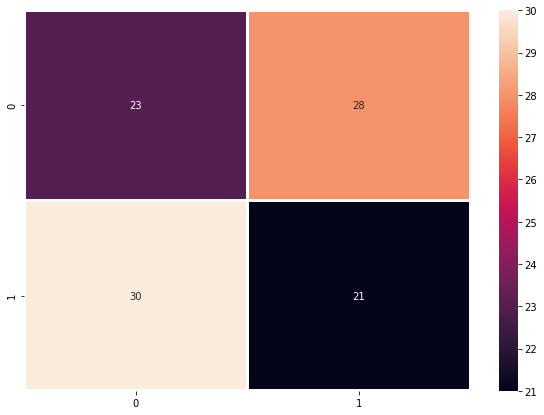

In [2]:
print('Criando classificações..')
labels = os.listdir('CatsAndDogs/Train')
print('Rótulos', labels)
#criando estruturas para métricas de avaliação, processo um pouco mais demorado
Y_pred = model.predict_generator(test_generator)
print('Preds Created')
y_pred = np.argmax(Y_pred, axis=1)
print('Preds 1D created')

classification = classification_report(test_generator.classes, y_pred, target_names=labels)
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(2)],
                  columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5)